# 1. Setup and Get Data

DEPENDENCIES

In [13]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [14]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### COLLECTING IMAGES OPENCV

In [15]:
import os
import time
import uuid
import cv2

In [16]:
uuid.uuid1() #just demonstrating uuid nothing else

UUID('9d81326c-d8b5-11ee-b770-50ebf630be0e')

In [17]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [18]:
cap = cv2.VideoCapture(2)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@97.490] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


### 1.3 Annotate Images with LabelMe

In [19]:
!labelme

2024-03-02 22:25:21,291 [INFO   ] __init__:get_config:67- Loading config file from: /home/zap/.labelmerc
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [20]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [21]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [23]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [24]:
images.as_numpy_iterator().next()

b'data/images/9e2a08c4-d8b5-11ee-b770-50ebf630be0e.jpg'

In [25]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [26]:
images = images.map(load_image)

In [27]:
images.as_numpy_iterator().next()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 51,  41,  31],
        [ 51,  43,  32],
        [ 52,  44,  33]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 54,  44,  34],
        [ 54,  46,  35],
        [ 54,  46,  35]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 56,  46,  36],
        [ 57,  47,  37],
        [ 57,  47,  37]],

       ...,

       [[112, 115,  84],
        [ 68,  71,  42],
        [ 42,  42,  16],
        ...,
        [  1,   1,   0],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[ 78,  82,  49],
        [ 66,  70,  37],
        [ 52,  55,  26],
        ...,
        [  0,   1,   0],
        [  1,   1,   0],
        [  0,   0,   0]],

       [[ 58,  62,  27],
        [ 61,  65,  32],
        [ 54,  57,  26],
        ...,
        [  0,   0,   0],
        [  0,   1,   0],
        [ 41,  42,  37]]

In [28]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [29]:
image_generator = images.batch(4).as_numpy_iterator()

In [30]:
plot_images = image_generator.next()

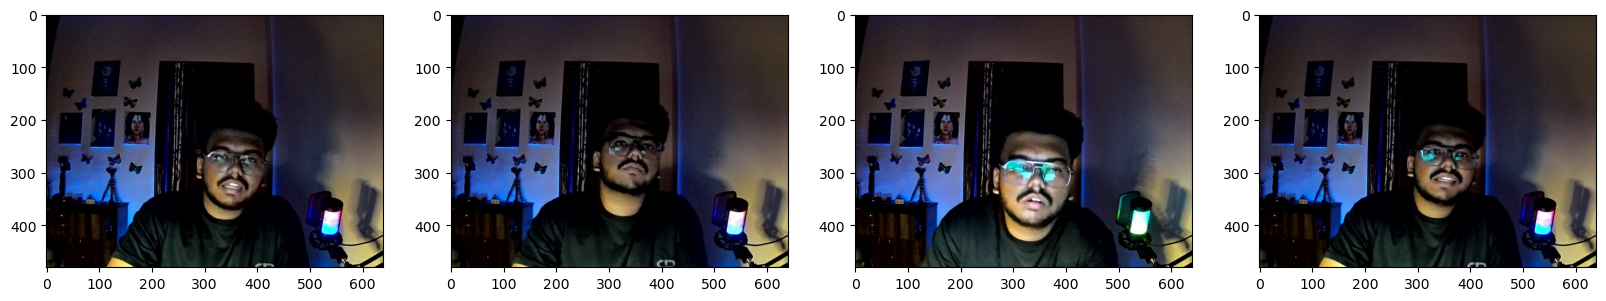

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

# 3. Partition Unaugmented Data

In [32]:
120*.7 # 84 to train

84.0

In [33]:
120*.15 # 18 and 18 to test and val

18.0

### 3.2 Move the Matching Labels

In [34]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [35]:
import albumentations as alb

In [36]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [37]:
img = cv2.imread(os.path.join('data','train', 'images','3327f0e6-d873-11ee-8f24-50ebf630be0e.jpg'))

In [38]:
with open(os.path.join('data', 'train', 'labels', '3230f0ca-d873-11ee-8f24-50ebf630be0e.json'), 'r') as f:
    label = json.load(f)

In [39]:
label['shapes'][0]['points']

[[231.30136986301372, 122.53424657534245],
 [380.2739726027397, 322.8767123287671]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords

[231.30136986301372, 122.53424657534245, 380.2739726027397, 322.8767123287671]

In [42]:
coords = list(np.divide(coords, [640,480,640,480]))

In [43]:
coords

[0.36140839041095896,
 0.25527968036529675,
 0.5941780821917808,
 0.6726598173515981]

### 4.4 Apply Augmentations and View Results

In [44]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [45]:
augmented['bboxes'][0][2:]

(0.49044140030441385, 0.7130593607305935)

In [46]:
augmented['bboxes']

[(0.15939117199391173,
  0.26785388127853876,
  0.49044140030441385,
  0.7130593607305935)]

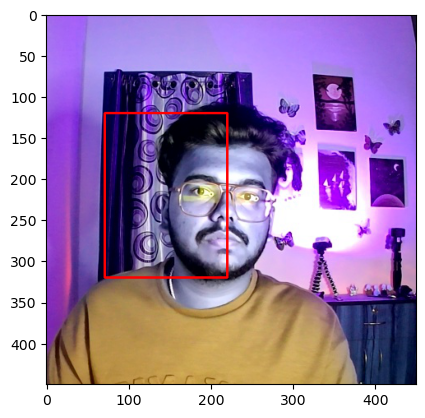

In [47]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [48]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [49]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [50]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [51]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [52]:
train_images.as_numpy_iterator().next()

array([[[0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        ...,
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ]],

       [[0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        ...,
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ]],

       [[0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        ...,
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ]],

       ...,

       [[0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0.        , 0.0627451 ],
        [0.00392157, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [53]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [54]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [57]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [58]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1140, 1140, 1020, 1020)

### 7.2 Create Final Datasets (Images/Labels)

In [59]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [60]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [61]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [62]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5674, 0.2703, 0.9146, 0.6987],
        [0.6567, 0.2117, 1.    , 0.6797],
        [0.8213, 0.278 , 1.    , 0.7656],
        [0.    , 0.231 , 0.337 , 0.6494],
        [0.621 , 0.2625, 1.    , 0.7505],
        [0.4524, 0.305 , 0.776 , 0.702 ],
        [0.4663, 0.1775, 0.9624, 0.689 ],
        [0.    , 0.2069, 0.2703, 0.6416]], dtype=float16))

### 7.3 View Images and Annotations

In [63]:
data_samples = train.as_numpy_iterator()

In [64]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


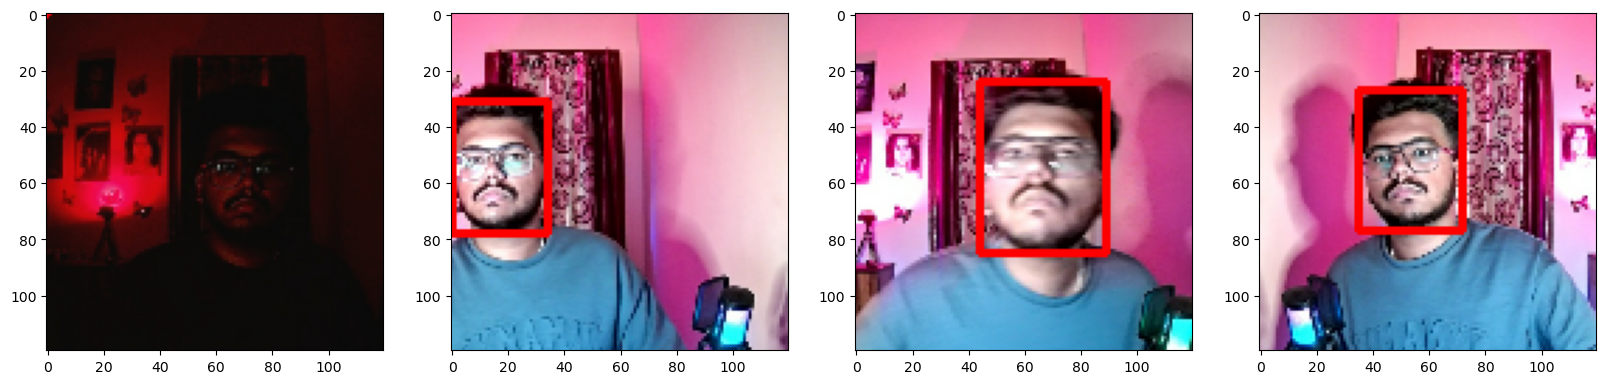

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [67]:
vgg = VGG16(include_top=False)

In [68]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [69]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [72]:
X, y = train.as_numpy_iterator().next()

In [73]:
X.shape

(8, 120, 120, 3)

In [74]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 346ms/step


In [75]:
classes, coords

(array([[0.50386006],
        [0.5102651 ],
        [0.5095335 ],
        [0.48809326],
        [0.44056407],
        [0.5383441 ],
        [0.5345578 ],
        [0.44671747]], dtype=float32),
 array([[0.50940853, 0.6189232 , 0.36603662, 0.56954056],
        [0.49414787, 0.56102717, 0.3340196 , 0.6733303 ],
        [0.41272742, 0.51356816, 0.32535318, 0.5373647 ],
        [0.39605284, 0.6666546 , 0.3671994 , 0.44200206],
        [0.47147304, 0.5938573 , 0.3517982 , 0.5264467 ],
        [0.45068848, 0.58216184, 0.31750825, 0.62251   ],
        [0.5586268 , 0.589166  , 0.30426905, 0.5229102 ],
        [0.46811044, 0.69486684, 0.31151745, 0.47495696]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [76]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [77]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [78]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [79]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [80]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.36256>

In [81]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7073785>

In [82]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.36256>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [83]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [84]:
model = FaceTracker(facetracker)

In [85]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [86]:
logdir='logs'

In [87]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [88]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
 85/630 [===>..........................] - ETA: 9:45 - total_loss: 0.6786 - class_loss: 0.1873 - regress_loss: 0.5850

KeyboardInterrupt: 

### 10.3 Plot Performance

In [89]:
hist.history

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

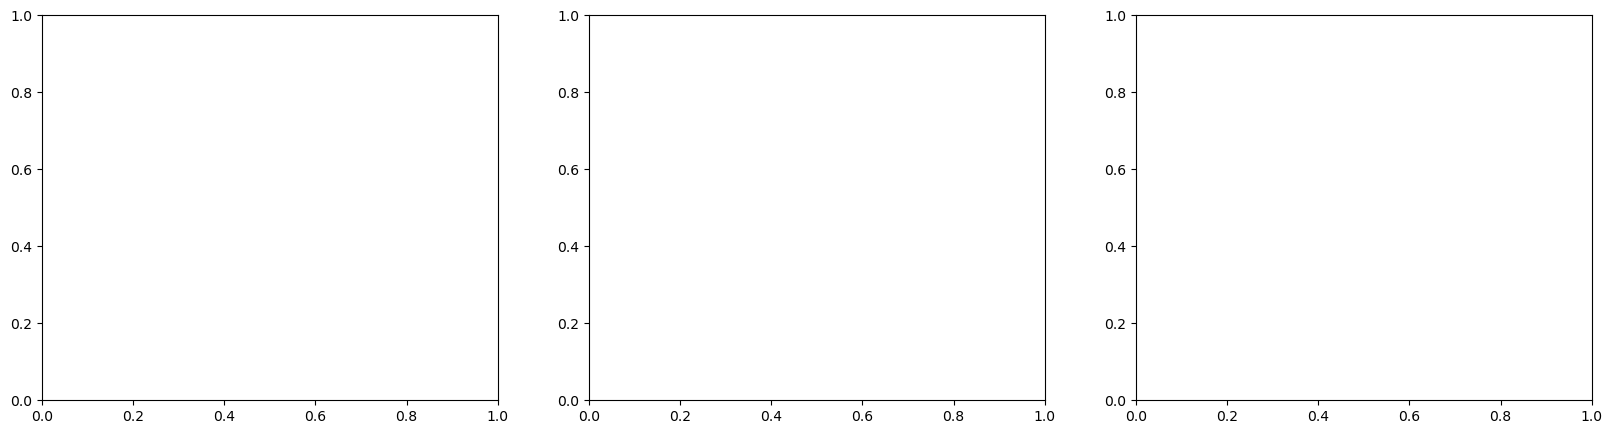

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [91]:
test_data = test.as_numpy_iterator()

In [92]:
test_sample = test_data.next()

In [93]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 213ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


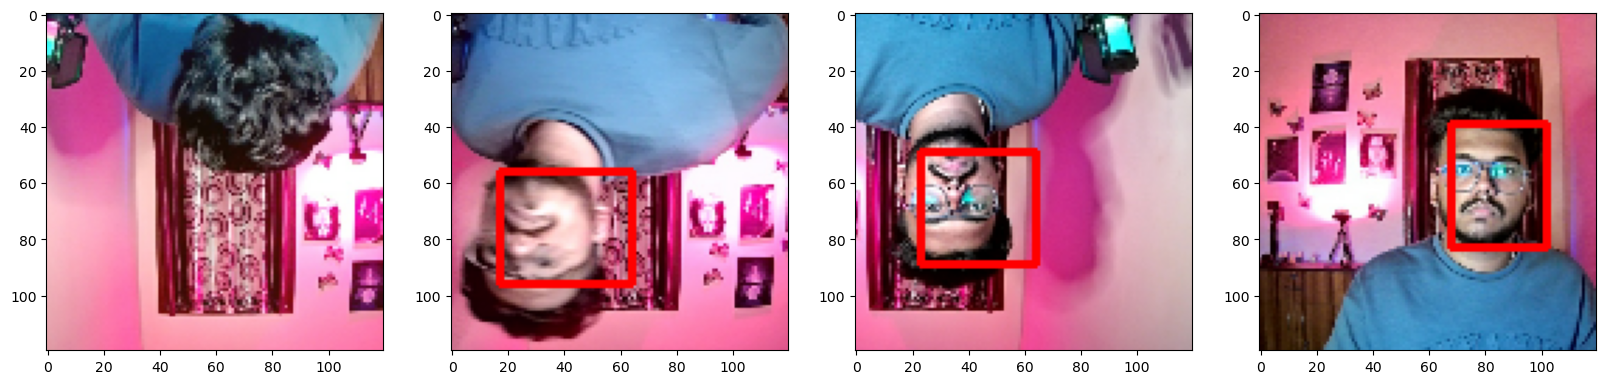

In [94]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [95]:
from tensorflow.keras.models import load_model

In [96]:
facetracker.save('facetracker.h5')

/home/zap/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [97]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [1]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined